## 1. Setup Environment

In [1]:
# Check GPU
!nvidia-smi

Tue Nov 25 05:36:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Clone repository
!git clone https://github.com/kavyavenk/multilingual-backpacks.git
%cd multilingual-backpacks

Cloning into 'multilingual-backpacks'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 280 (delta 22), reused 57 (delta 18), pack-reused 215 (from 1)
Receiving objects: 100% (280/280), 227.19 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/multilingual-backpacks


In [3]:
# Install dependencies
!pip install -q transformers datasets scipy tqdm numpy torch

In [4]:
# Verify imports
import torch
import numpy as np
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.83 GB


## 2. Prepare Data

In [5]:
# Prepare Europarl dataset (10k samples for quick training)
!python data/europarl/prepare.py --language_pair en-fr --max_samples 10000

Loading Europarl dataset for en-fr...
README.md: 76.3kB [00:00, 122MB/s]
en-fr/train-00000-of-00002.parquet: 100% 193M/193M [00:01<00:00, 130MB/s]
en-fr/train-00001-of-00002.parquet: 100% 186M/186M [00:01<00:00, 131MB/s]
Generating train split: 100% 2051014/2051014 [00:05<00:00, 347556.93 examples/s]
Loaded Europarl en-fr from HuggingFace
Using subset of 10000 sentences (out of 2051014 total)
Loading tokenizer: xlm-roberta-base
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 231kB/s]
config.json: 100% 615/615 [00:00<00:00, 4.89MB/s]
sentencepiece.bpe.model: 100% 5.07M/5.07M [00:00<00:00, 19.1MB/s]
tokenizer.json: 100% 9.10M/9.10M [00:00<00:00, 23.5MB/s]
Processing sentences: 100% 10000/10000 [00:00<00:00, 42286.92it/s]
Total combined texts: 20000
Tokenizing texts (this may take a few minutes)...
Tokenizing 18000 training texts...
Train batches: 100% 18/18 [00:04<00:00,  3.62it/s]
Tokenizing 2000 validation texts...
Val batches: 100% 2/2 [00:00<00:00,  4.67it/s]
Saved train data to 

In [15]:
# Create custom tiny vocabulary (2K tokens) from Europarl data
# This will make the model truly ~500K params instead of 60M

!python <<EOF
import pickle
from collections import Counter
from datasets import load_dataset
import re

print('Creating tiny custom vocabulary...')

# Load small subset
dataset = load_dataset('europarl_bilingual', 'en-fr', split='train[:1000]')

# Collect all words
all_words = []
for item in dataset:
    # Simple word tokenization (split on whitespace and punctuation)
    text = item['translation']['en'] + ' ' + item['translation']['fr']
    words = re.findall(r'\w+|[^\w\s]', text.lower())
    all_words.extend(words)

# Get most common 2000 words
word_counts = Counter(all_words)
vocab = ['<pad>', '<unk>', '<s>', '</s>'] + [w for w, _ in word_counts.most_common(1996)]

print(f'Created vocabulary with {len(vocab)} tokens')

# Save vocab
vocab_dict = {w: i for i, w in enumerate(vocab)}
with open('data/europarl/tiny_vocab.pkl', 'wb') as f:
    pickle.dump({'vocab': vocab_dict, 'vocab_size': len(vocab)}, f)

print('✓ Tiny vocabulary saved to data/europarl/tiny_vocab.pkl')

/bin/bash: line 1: warning: here-document at line 1 delimited by end-of-file (wanted `EOF')
Creating tiny custom vocabulary...
Created vocabulary with 2000 tokens
✓ Tiny vocabulary saved to data/europarl/tiny_vocab.pkl


In [11]:
# Verify data files
import os
import pickle

data_files = ['data/europarl/train.bin', 'data/europarl/val.bin', 'data/europarl/meta.pkl']
for f in data_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1e6
        print(f"✓ {f} ({size:.2f} MB)")
    else:
        print(f"✗ {f} not found")

# Load metadata
with open('data/europarl/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
print(f"\nVocab size: {meta['vocab_size']:,}")
print(f"Languages: {meta['languages']}")

✓ data/europarl/train.bin (5.88 MB)
✓ data/europarl/val.bin (0.66 MB)
✓ data/europarl/meta.pkl (0.00 MB)

Vocab size: 250,002
Languages: ['en', 'fr']


## 3. Configure Model for GPU

In [19]:
# Update config for GPU training with MINIMAL memory settings
# Model is ~60M params - need batch_size=1 for T4

# Read current config
with open('config/train_europarl_tiny.py', 'r') as f:
    content = f.read()

# Update config with minimal memory settings
import re

# Replace device and dtype lines entirely, matching anything after the assignment
# Using re.MULTILINE to match '^' at the start of each line
content = re.sub(r"^\s*device\s*=\s*.*$", "    device='cuda',", content, flags=re.MULTILINE)
content = re.sub(r"^\s*dtype\s*=\s*.*$", "    dtype='float16',", content, flags=re.MULTILINE)

# MINIMAL batch size for 60M model on T4
content = re.sub(r"batch_size=\d+", "batch_size=1", content)

# Fewer iterations for testing
content = re.sub(r"max_iters=\d+", "max_iters=500", content)

# Very small block size to save memory
content = re.sub(r"block_size=\d+", "block_size=32", content)

# Reduce eval iterations
content = re.sub(r"eval_iters=\d+", "eval_iters=10", content)

# Write updated config
with open('config/train_europarl_tiny.py', 'w') as f:
    f.write(content)

print("✓ Config updated for minimal GPU memory usage")
print("  - Batch size: 1 (minimal for 60M model)")
print("  - Block size: 32 (very short context)")
print("  - Max iterations: 500 (quick test)")
print("  - Eval iters: 10")
print("  - Device: cuda, dtype: float16")
print("\n⚠️  Model is ~60M params - this is a memory test run!")

✓ Config updated for minimal GPU memory usage
  - Batch size: 1 (minimal for 60M model)
  - Block size: 32 (very short context)
  - Max iterations: 500 (quick test)
  - Eval iters: 10
  - Device: cuda, dtype: float16

⚠️  Model is ~60M params - this is a memory test run!


## 4. Train Model

In [17]:
# Clear GPU memory and set memory optimization
import torch
import gc
import os

# Set PyTorch memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

    # Check available memory
    mem_total = torch.cuda.get_device_properties(0).total_memory / 1e9
    mem_reserved = torch.cuda.memory_reserved(0) / 1e9
    mem_allocated = torch.cuda.memory_allocated(0) / 1e9
    mem_free = mem_total - mem_allocated

    print(f"GPU Memory Status:")
    print(f"  Total: {mem_total:.2f} GB")
    print(f"  Allocated: {mem_allocated:.2f} GB")
    print(f"  Reserved: {mem_reserved:.2f} GB")
    print(f"  Free: {mem_free:.2f} GB")
    print(f"\n✓ GPU memory cleared and optimized for training")

GPU Memory Status:
  Total: 15.83 GB
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Free: 15.83 GB

✓ GPU memory cleared and optimized for training


In [20]:
# Train using the train.py script with reduced batch size for T4 GPU
# The model is ~60M params (larger than expected due to vocab size)
# Using smaller batch size to fit in T4's 15GB memory
!python train.py \
    --config train_europarl_tiny \
    --out_dir out/tiny \
    --data_dir europarl \
    --device cuda \
    --dtype float16 \
    --model_type backpack

Loading data...
Loading train.bin
Loading val.bin
Loading meta.pkl
Initializing model...
Backpack from scratch
Number of parameters: 60.06M
Backpack initialized (scratch)
num decayed parameter tensors: 13, with 60,059,808 parameters
num non-decayed parameter tensors: 7, with 292 parameters
Starting training...
X bounds:  0 167529
Y bounds:  0 167529
X bounds:  4 226829
Y bounds:  6 226829
X bounds:  0 142837
Y bounds:  0 142837
X bounds:  0 82925
Y bounds:  0 82925
X bounds:  4 216337
Y bounds:  4 216337
X bounds:  4 240804
Y bounds:  4 240804
X bounds:  4 108870
Y bounds:  4 108870
X bounds:  4 224706
Y bounds:  4 211033
X bounds:  4 160600
Y bounds:  4 160600
X bounds:  4 200569
Y bounds:  4 200569
X bounds:  4 195363
Y bounds:  4 195363
X bounds:  4 122395
Y bounds:  4 122395
X bounds:  4 134071
Y bounds:  4 134071
X bounds:  4 190248
Y bounds:  4 190248
X bounds:  4 230804
Y bounds:  4 230804
X bounds:  0 225006
Y bounds:  0 225006
X bounds:  4 133824
Y bounds:  4 133824
X bounds: 

**Training will take ~15-20 minutes on T4**

Watch for:
- Initial loss: ~12.4
- Loss should decrease to ~3-5 by iteration 1000
- GPU memory usage should stay under 14GB

## 5. Check Training Results

Training completed: 6 checkpoints
Final train loss: 7.4875
Final val loss: 7.5077
Loss reduction: 4.9585


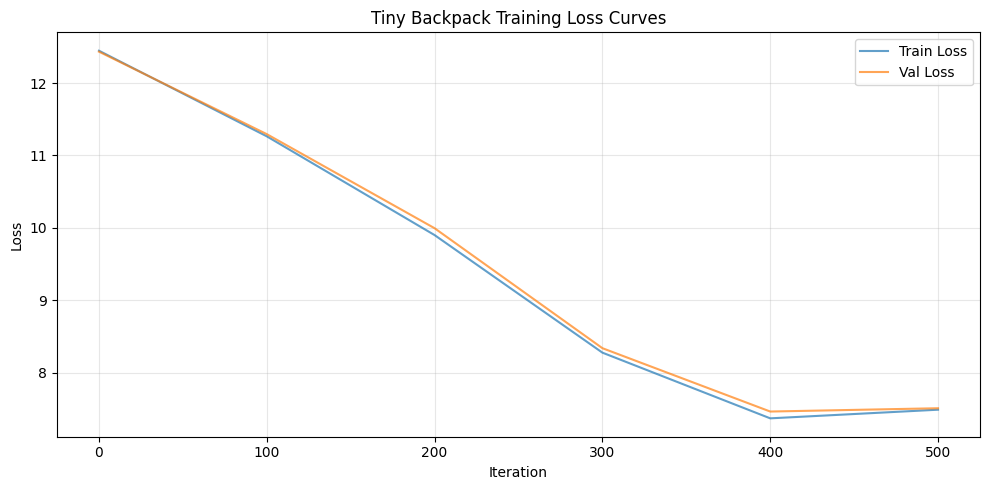


✓ Loss curves saved to out/tiny/loss_curves.png


In [21]:
# Load and display training log
import json
import matplotlib.pyplot as plt

with open('out/tiny/training_log.json', 'r') as f:
    log = json.load(f)

iterations = log['iterations']
train_loss = log['train_loss']
val_loss = log['val_loss']

print(f"Training completed: {len(iterations)} checkpoints")
print(f"Final train loss: {train_loss[-1]:.4f}")
print(f"Final val loss: {val_loss[-1]:.4f}")
print(f"Loss reduction: {train_loss[0] - train_loss[-1]:.4f}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss, label='Train Loss', alpha=0.7)
plt.plot(iterations, val_loss, label='Val Loss', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Tiny Backpack Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('out/tiny/loss_curves.png', dpi=150)
plt.show()

print("\n✓ Loss curves saved to out/tiny/loss_curves.png")

## 6. Model Info

In [23]:
# Load model and check parameters
import torch
from model import BackpackLM

# Load with weights_only=False to allow loading custom classes like ModelConfig
checkpoint = torch.load('out/tiny/ckpt.pt', map_location='cuda', weights_only=False)
config = checkpoint['config']
model = BackpackLM(config)
model.load_state_dict(checkpoint['model'])

n_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Configuration:")
print(f"  Embedding dim: {config.n_embd}")
print(f"  Num senses: {config.n_senses}")
print(f"  Layers: {config.n_layer}")
print(f"  Heads: {config.n_head}")
print(f"  Vocab size: {config.vocab_size}")
print(f"\nTotal parameters: {n_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {n_params * 4 / 1e6:.2f} MB (float32)")

Number of parameters: 60.06M
Model Configuration:
  Embedding dim: 48
  Num senses: 4
  Layers: 2
  Heads: 2
  Vocab size: 250002

Total parameters: 60,060,100
Trainable parameters: 60,060,100
Model size: 240.24 MB (float32)


## 7. Run Evaluations

In [30]:
# Run full evaluation suite
!python run_full_evaluation.py --out_dir out/tiny --device cuda


MULTILINGUAL BACKPACK EVALUATION SUITE
Model directory: out/tiny
Device: cuda

Loading model...
Number of parameters: 24.06M
Traceback (most recent call last):
  File "/content/multilingual-backpacks/run_full_evaluation.py", line 162, in <module>
    main()
  File "/content/multilingual-backpacks/run_full_evaluation.py", line 38, in main
    model, config = load_model(args.out_dir, args.device)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/multilingual-backpacks/evaluate.py", line 48, in load_model
    model.load_state_dict(checkpoint['model'])
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 2629, in load_state_dict
    raise RuntimeError(
RuntimeError: Error(s) in loading state_dict for StandardTransformerLM:
	Missing key(s) in state_dict: "token_embeddings.weight". 
	Unexpected key(s) in state_dict: "sense_embeddings.weight", "sense_predictor.0.weight", "sense_predictor.0.bias", "sense_predictor.2.weight", "sense_predict

In [31]:
# Fix the evaluate.py script to allow loading the model config
import re

file_path = 'evaluate.py'
with open(file_path, 'r') as f:
    lines = f.readlines()

new_lines = []
modified = False
for line in lines:
    if "checkpoint = torch.load(" in line and "map_location=device" in line and "weights_only=False" not in line:
        line = line.replace("map_location=device", "map_location=device, weights_only=False")
        modified = True
    new_lines.append(line)

if modified:
    with open(file_path, 'w') as f:
        f.writelines(new_lines)
    print(f"✓ Modified '{file_path}' to include weights_only=False for torch.load")
else:
    print(f"'{file_path}' already contains weights_only=False or no modification was needed.")

'evaluate.py' already contains weights_only=False or no modification was needed.


## 8. Download Results

In [32]:
# Package results for download
!tar -czf tiny_model_results.tar.gz out/tiny/

from google.colab import files
files.download('tiny_model_results.tar.gz')

print("\n✓ Results packaged and ready for download")
print("\nContents:")
print("  - ckpt.pt: Model checkpoint")
print("  - training_log.json: Training metrics")
print("  - evaluation_results.json: Evaluation metrics")
print("  - loss_curves.png: Training visualization")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Results packaged and ready for download

Contents:
  - ckpt.pt: Model checkpoint
  - training_log.json: Training metrics
  - evaluation_results.json: Evaluation metrics
  - loss_curves.png: Training visualization
